# Sequence-to-Seqeunce

* https://wikidocs.net/24996

* Sequence-to-sequence(Seq2Seq)는 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력하는 모델
* 예를 들어, 한국어 도메인을 가지는 문장을 입력해 중국어 도메인에 해당하는 문장을 얻을 수 있음
* Seq2Seq는 다른 특별한 기술을 이용하는 것이 아닌 지금까지 배운 RNN 기술들을 조합해 만들며, encoder와 decoder로 구성

# 기계 번역 데이터

* 일반적인 자연어 처리의 경우, 입력 시퀀스와 출력 시퀀스의 길이가 동일함
* Seq2Seq는 입력 시퀀스와 출력 시퀀스의 길이가 다를 수 있다고 가정
* Seq2Seq에는 인코더의 입력, 디코더의 입력, 디코더의 출력에 해당하는 데이터가 필요



* 데이터는 영어 문장과 그에 해당하는 프랑스어 문장이 존재하는 기계 번역 데이터를 사용
* url 주소에서 데이터를 받아오고, 필요없는 열(lic)은 제거



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

* http://www.manythings.org/anki/fra-eng.zip

In [2]:
df = pd.read_csv('fra-eng/fra.txt', names=['src', 'tar', 'lic'], sep='\t')
del df['lic']

In [3]:
len(df)     

229803

*   데이터를 모두 사용할 경우 많은 시간이 소요되기 때문에, 일부 데이터만 사용
*   목표 데이터에는 시작과 끝을 나타내는 토큰이 포함되어야 함
*   여기서는 '\t'와 '\n'을 각각 시작과 끝을 나타내는 토큰으로 사용

In [4]:
df = df.sample(30000)
df['tar'] = df['tar'].apply(lambda x: '\t ' + x + ' \n')
df.reset_index(inplace=True, drop=True)

df.head(3)

,src,tar
0,I think you know what has to be done.,\t Je pense que tu sais ce qui doit être fait. \n
1,I'm coming right home.,\t J'arrive juste chez moi. \n
2,That's good enough.,\t C'est suffisamment bon. \n




*   해당 예제에서는 글자 단위로 예측, 따라서 글자 집합을 구축해주어야 함
*   구축한 다음, 정렬해 인덱스를 부여해 글자에 해당하는 사전을 만듬
*   사전은 글자를 모델에 투입하도록 변환하거나 예측시 반환되는 인덱스들을 글자로 변환할 때 사용



In [5]:
#프랑스어 단어사전
src_vocab = set()
for line in df.src:
    for char in line:
        src_vocab.add(char)

#영어 단어사전
tar_vocab = set()
for line in df.tar:
    for char in line:
        tar_vocab.add(char)

In [6]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))

src_vocab_size = len(src_vocab) + 1
tar_vocab_size = len(tar_vocab) + 1

src_to_idx = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_idx = dict([(word, i+1) for i, word in enumerate(tar_vocab)])


print(src_to_idx)
print(tar_to_idx)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, "'": 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'X': 46, 'Y': 47, 'Z': 48, 'a': 49, 'b': 50, 'c': 51, 'd': 52, 'e': 53, 'f': 54, 'g': 55, 'h': 56, 'i': 57, 'j': 58, 'k': 59, 'l': 60, 'm': 61, 'n': 62, 'o': 63, 'p': 64, 'q': 65, 'r': 66, 's': 67, 't': 68, 'u': 69, 'v': 70, 'w': 71, 'x': 72, 'y': 73, 'z': 74, '\xa0': 75, '\xad': 76, 'é': 77, 'ï': 78, '’': 79}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, "'": 8, ',': 9, '-': 10, '.': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '?': 24, 'A': 25, 'B': 26, 'C': 27, 'D': 28, 'E': 29, 'F': 30, 'G': 31, 'H': 32, 'I': 33, 

*   인코더에 입력될 입력 데이터를 구성
*   문장의 글자 하나씩을 사전을 이용해 인덱스로 변환해 리스트에 넣음



In [7]:
#인코더 입력데이터
encoder_input = []
for line in df.src:
    encoder_input.append([src_to_idx[w] for w in line])

encoder_input[0]     

[31,
 1,
 68,
 56,
 57,
 62,
 59,
 1,
 73,
 63,
 69,
 1,
 59,
 62,
 63,
 71,
 1,
 71,
 56,
 49,
 68,
 1,
 56,
 49,
 67,
 1,
 68,
 63,
 1,
 50,
 53,
 1,
 52,
 63,
 62,
 53,
 9]



*   디코더에 입력될 입력 데이터를 구성
*   인코더 입력 데이터 처리와 동일하나, 목표 데이터에 해당하는 사전을 사용해주어야 함



In [8]:
#디코더 입력데이터
decoder_input = []
for line in df.tar:
    decoder_input.append([tar_to_idx[w] for w in line])  

decoder_input[0]

[1,
 3,
 34,
 55,
 3,
 66,
 55,
 64,
 69,
 55,
 3,
 67,
 71,
 55,
 3,
 70,
 71,
 3,
 69,
 51,
 59,
 69,
 3,
 53,
 55,
 3,
 67,
 71,
 59,
 3,
 54,
 65,
 59,
 70,
 3,
 90,
 70,
 68,
 55,
 3,
 56,
 51,
 59,
 70,
 11,
 3,
 2]


*   디코더의 출력과 비교할 목표 데이터를 구성
*   디코더의 입력 데이터를 구성할 때와 동일하나, 시작 토큰을 제외해주어야 함



In [9]:
#디코더 출력과 비교할 타켓데이터
decoder_target = []
for line in df.tar:
    decoder_target.append([tar_to_idx[w] for w in line if w != '\t'])  #시작토큰 제외
    
decoder_target[0]

[3,
 34,
 55,
 3,
 66,
 55,
 64,
 69,
 55,
 3,
 67,
 71,
 55,
 3,
 70,
 71,
 3,
 69,
 51,
 59,
 69,
 3,
 53,
 55,
 3,
 67,
 71,
 59,
 3,
 54,
 65,
 59,
 70,
 3,
 90,
 70,
 68,
 55,
 3,
 56,
 51,
 59,
 70,
 11,
 3,
 2]



* 각각의 데이터를 동일한 길이로 맞춰줌
* 길이를 맞춰줄 때는 해당 데이터의 최대 길이로 맞춰줌
* 원 핫 인코딩을 통해 원 핫 벡터로 변환



In [10]:
max_src_len = max([len(line) for line in df.src])
max_tar_len = max([len(line) for line in df.tar])

print(max_src_len, max_tar_len)

239 309


In [11]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

In [12]:
# 원핫 인코딩
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

## 인코더(Encoder)

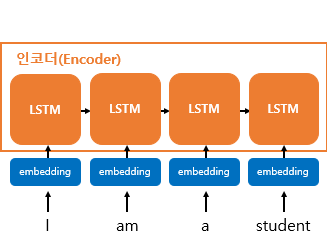



* encoder는 입력 문장을 받는 여러 개의 RNN cell
* 입력은 단어 토큰화로 단어 단위로 쪼개지고, 이는 각 시점의 encoder 입력이 됨
* encoder는 모든 단어를 입력받고 마지막 시점의 은닉 상태를 decoder RNN cell의 첫번째 은닉 상태로 넘겨주며,
이를 컨텍스트 벡터(context vector)라고 함
* encoder는 입력 시퀀스를 컨텍스트 벡터라는 고정 길이 벡터로 압축하고자 함



## 인코더 모델 구성



*   encoder의 구성은 일반 lstm 모델과 동일
*   lstm 안의 return_state는 은닉 상태를 반환해줘 seq2seq 모델을 구성할 때 필요함



In [13]:
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(256, return_state=True)

encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

In [14]:
encoder_inputs

<KerasTensor: shape=(None, None, 80) dtype=float32 (created by layer 'input_1')>

In [15]:
encoder_outputs

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>

In [16]:
encoder_states

[<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>]

## 디코더(Decoder)

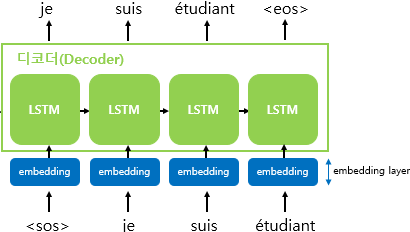

* decoder는 encoder와 마찬가지로 여러 개의 RNN cell로 이루어짐
* decoder의 처음 입력은 시작을 나타내는 토큰을 입력하며, 이 토큰 다음에 등장할 단어를 예측
* 처음 셀에서 단어를 예측한 결과는 다시 다음 시점의 decoder 입력으로 사용
* 위 과정을 반복해, 끝을 나타내는 토큰이 예측될 때까지 반복
* 요약하자면 decoder는 encoder에서 넘겨받은 컨텍스트 벡터를 활용해 시퀀스를 만들어 냄



### 교사 강요(Teacher Forcing)


* 앞서 설명한 seq2seq 모델을 잘 살펴보면 디코더의 입력이 필요하지 않음을 알 수 있음
* 예측이 잘못됐을 경우, 잘못된 예측이 다음 시점으로 입력돼 연쇄적으로 잘못된 예측을 함
* 이를 해결하기 위해 **디코더의 다음 시점의 입력으로 이전 시점의 출력이 아닌, 정답을 주어 이를 방지함**





## 디코더 모델 구성



*   모델의 구성은 encoder과 거의 유사함
*   lstm의 return_sequences는 출력을 시퀀스로 반환할 때 사용
*   decoder_lstm을 사용할 때는 initial_state를 인코더의 은닉 상태로 설정
*   마지막으로 Dense layer와 softmax를 통과해 예측 글자에 해당하는 인덱스를 반환



In [17]:
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

In [18]:
decoder_outputs

<KerasTensor: shape=(None, None, 256) dtype=float32 (created by layer 'lstm_1')>

In [19]:
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [20]:
decoder_softmax_layer

In [21]:
decoder_outputs

<KerasTensor: shape=(None, None, 101) dtype=float32 (created by layer 'dense')>

## Seq2Seq 모델



*   앞서 구성한 encoder와 decoder를 결합해 seq2seq model을 구성
*   구성한 모델과 준비한 데이터를 사용해 기계 번역 학습



In [22]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 80)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 101)]          0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 256),                345088    ['input_1[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [25]:
history = model.fit(x=[encoder_input, decoder_input], y=decoder_target,
                        batch_size=32, epochs=1, validation_split=0.2)

MemoryError: Unable to allocate 2.79 GiB for an array with shape (24000, 309, 101) and data type float32

*현재 GPU가 없는 까닭으로 1번의 epoch한 한다..*

In [ ]:
#pd.DataFrame(history.history).plot();

## 예측



*   일반 모델과는 다르게, seq2seq 모델은 모델 예측 프로세스가 다름
*   예측할 때는 인덱스 하나씩을 예측하게 되며, 예측한 인덱스를 저장하고 이를 다시 입력으로 사용해 종료 토큰이 나올때까지 반복
*   마지막으로 예측한 인덱스들을 사전을 통해 글자들로 변환해 최종 예측을 얻음



In [ ]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

decoder_state_input_h = Input(shape=(256))
decoder_state_input_c = Input(shape=(256))

decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)

decoder_states = [state_h, state_c]

decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_state_inputs,
                      outputs=[decoder_outputs] + decoder_states)

In [ ]:
idx_to_src = dict((i, char) for char, i in src_to_idx.items())
idx_to_tar = dict((i, char) for char, i in tar_to_idx.items())

In [ ]:
def predict_decode(input_seq):
    state_value = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1,tar_vocab_size))
    target_seq[0, 0, tar_to_idx['\t']] = 1
    
    stop = False
    result = ''
    
    while not stop:
        output_tokens, h, c = decoder_model.predict([target_seq] + state_value)
        
        sampled_token_idx = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx_to_tar[sampled_token_idx]
        
        result += sampled_char
        
        if sampled_char == '\n' or len(result) > max_tar_len:
            stop = True
            
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_idx] = 1.
        
        state_value = [h, c]
        
    return result

In [ ]:
for seq_idx in range(0, 30000, 3000):
    input_seq = encoder_input[seq_idx:seq_idx+1]
    result = predict_decode(input_seq)
    
    print('입력 문장 :', df.src[seq_idx])
    print('실제 정답 :', df.tar[seq_idx][1:len(df.tar[seq_idx])-1])   #시작, 종료토큰 제외
    print('번역 결과 :', result[:len(result)-1], '\n')